In [1]:
# general libs

import sys
sys.path.append("..")
import time
import glob
# misc
import cv2
import numpy as np

# pytorch libs
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# custom libs
from src.config import *
#from src.miou_utils import compute_iu, fast_cm
from src.util import *
from utils.helpers import prepare_img

In [2]:
def create_segmenter(
    net, pretrained, num_classes
    ):
    """Create Encoder; for now only ResNet [50,101,152]"""
    from models.resnet import rf_lw50, rf_lw101, rf_lw152
    if str(net) == '50':
        return rf_lw50(num_classes, imagenet=pretrained)
    elif str(net) == '101':
        return rf_lw101(num_classes, imagenet=pretrained)
    elif str(net) == '152':
        return rf_lw152(num_classes, imagenet=pretrained)
    else:
        raise ValueError("{} is not supported".format(str(net)))


In [3]:
def test_24(path,segmenter):
    from utils.helpers import prepare_img

    filelist = os.listdir(path)
    path = os.path.abspath(path)
    cmap = np.load('../utils/cmap.npy')
    n_cols = 3 # 1 - for image, 1 - for GT
    n_rows = len(filelist)

    plt.figure(figsize=(16, 12))
    idx = 1
    with torch.no_grad():
        for i,item in enumerate(filelist):
            if item.endswith('mask.png')==False:
                filepath = os.path.join(path, item)
                image = np.array(Image.open(filepath))
                msk = cmap[np.array(Image.open(filepath.replace('.png', '_mask.png')))] #是对mask的处理
            
                orig_size = image.shape[:2][::-1]
            
            
                plt.subplot(n_rows, n_cols, idx)
                plt.imshow(image)
                plt.title('img')
                plt.axis('off')
                idx += 1
        
                plt.subplot(n_rows, n_cols, idx)
                plt.imshow(msk)
                plt.title('gt')
                plt.axis('off')
                idx += 1
            
                image = torch.tensor(prepare_img(image).transpose(2, 0, 1)[None]).float()
                segm=segmenter(image)[0].data.cpu().numpy().transpose(1, 2, 0)
                segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC)
                segm = cmap[segm.argmax(axis=2).astype(np.uint8)]
                segm = transforms.ToPILImage()(segm)
            
                plt.subplot(n_rows, n_cols, idx)
                plt.imshow(segm)
                plt.axis('off')
            

In [4]:
segmenter = nn.DataParallel(
        create_segmenter('50', True, 4)
    )
segmenter.load_state_dict(torch.load('ckpt/checkpoint.pth.tar','cpu')['segmenter'])
segmenter.eval()

DataParallel(
  (module): ResNetLW(
    (do): Dropout(p=0.5)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): S

f:\anaconda\envs\lw\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


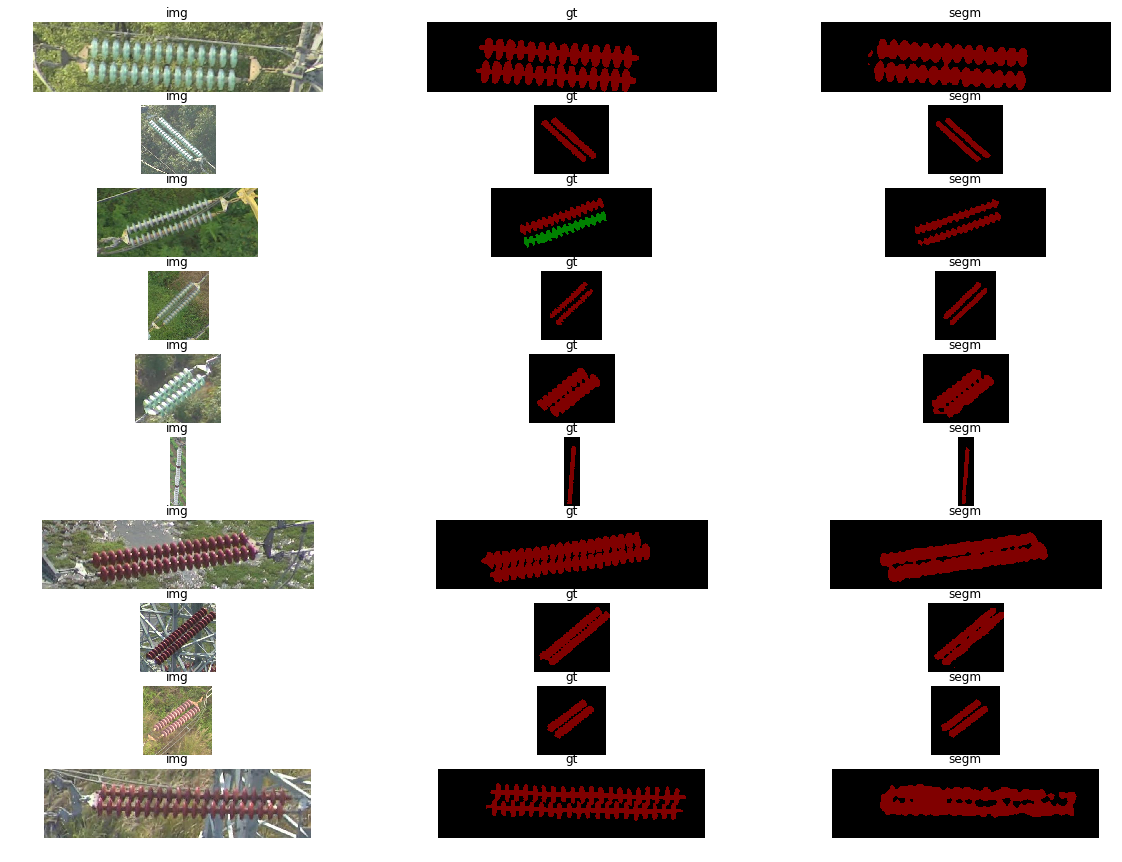

In [5]:
path="./test"
path = os.path.abspath(path)
filelist = os.listdir(path)
cmap = np.load('../utils/cmap.npy')
n_cols = 3 # 1 - for image, 1 - for GT
n_rows = 10

plt.figure(figsize=(20, 15))

idx = 1
with torch.no_grad():
    for i,item in enumerate(filelist):
        if item.endswith('mask.png')==False:
            filepath = os.path.join(path, item)
            image = np.array(Image.open(filepath))
            msk = cmap[np.array(Image.open(filepath.replace('.png', '_mask.png')))] #是对mask的处理
            orig_size = image.shape[:2][::-1]
            
            
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(image)
            plt.title('img')
            plt.axis('off')
            idx += 1
    
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(msk)
            plt.title('gt')
            plt.axis('off')
            idx += 1
            
            image = torch.tensor(prepare_img(image).transpose(2, 0, 1)[None]).float()
            segm=segmenter(image)[0].data.cpu().numpy().transpose(1, 2, 0)
            segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC)
            segm = cmap[segm.argmax(axis=2).astype(np.uint8)]
            segm = transforms.ToPILImage()(segm)
            
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(segm)
            plt.title('segm')
            plt.axis('off')
            idx+=1     